In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('DATA/infrastructure_deliverables.csv')

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(df.info())

| Settlement Name   | Project Type   | Project Status   | Completion Percentage   | Start Date   | End Date   | Project Budget (KES)   | Infrastructure Level   | Population Density   | Growth Rate   | Need New Infrastructure   |
|:------------------|:---------------|:-----------------|:------------------------|:-------------|:-----------|:-----------------------|:-----------------------|:---------------------|:--------------|:--------------------------|
| Machakos          | Hospital       | Completed        | 100                     | 2020-05-10   | 2021-07-17 | 31000000               | Low                    | Low                  | Stable        | 0                         |
| Garissa           | Road           | Completed        | 100                     | 2020-02-17   | 2021-03-25 | 34000000               | High                   | High                 | Slow          | 0                         |
| Mandera           | Electricity    | Delayed          | 10                      | 

The columns Project Type, Project Status, Infrastructure Level, Population Density, and Growth Rate are categorical and will need to be encoded before we can use them in our models. The columns Start Date and End Date are datetime, but since they have null values, we will drop these columns for this analysis. The target variable is Need New Infrastructure. We will build a classification model to predict this target variable.

We will also create a new target variable is_delayed which is 1 if Project Status is 'Delayed' and 0 otherwise to predict the likelihood of project delays.

We will drop the Start Date, End Date and Settlement Name columns as they are not relevant for our model.

In [2]:
from sklearn.preprocessing import OneHotEncoder

# Drop the `Start Date`, `End Date` and `Settlement Name` columns
df.drop(['Start Date', 'End Date', 'Settlement Name'], axis=1, inplace=True)

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cols = encoder.fit_transform(df[['Project Type', 'Project Status', 'Infrastructure Level', 'Population Density', 'Growth Rate']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['Project Type', 'Project Status', 'Infrastructure Level', 'Population Density', 'Growth Rate']))

# Concatenate the encoded columns with the original DataFrame
df = pd.concat([df.drop(['Project Type', 'Project Status', 'Infrastructure Level', 'Population Density', 'Growth Rate'], axis=1), encoded_df], axis=1)

# Create a new target variable `is_delayed` which is 1 if `Project Status` is 'Delayed' and 0 otherwise
df['is_delayed'] = df['Project Status_Delayed'].astype(int)

In [3]:
#Now we will split the data into features (X) and target variable (Need New Infrastructure) then split the data 
#into training and testing sets. We will then initialize and train a Random Forest Classifier model to predict the need 
#for new infrastructure and evaluate the model on the test set. 
#We will also print the top 5 features contributing to the need for new infrastructure
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into features and target variable for predicting project delays
X_delay = df.drop(['Need New Infrastructure', 'is_delayed', 'Project Status_Completed', 'Project Status_Delayed', 'Project Status_In Progress', 'Project Status_Not Started'], axis=1)
y_delay = df['is_delayed']

# Split the data into training and testing sets for predicting project delays
X_train_delay, X_test_delay, y_train_delay, y_test_delay = train_test_split(X_delay, y_delay, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier model for predicting project delays
model_delay = RandomForestClassifier(random_state=42)
model_delay.fit(X_train_delay, y_train_delay)

# Make predictions on the test set for predicting project delays
y_pred_delay = model_delay.predict(X_test_delay)

# Evaluate the model on the test set for predicting project delays
accuracy_delay = accuracy_score(y_test_delay, y_pred_delay)
report_delay = classification_report(y_test_delay, y_pred_delay)
cm_delay = confusion_matrix(y_test_delay, y_pred_delay)

# Print the evaluation metrics for predicting project delays
print(f"Accuracy for predicting project delays: {accuracy_delay}")
print("Classification Report for predicting project delays:\n", report_delay)
print("Confusion Matrix for predicting project delays:\n", cm_delay)

# Get the list of encoded column names by dropping the target variables and non-encoded columns from the dataframe's columns
encoded_column_names = X_delay.columns

# Get the feature importances from the trained model for predicting project delays
importances_delay = model_delay.feature_importances_

# Create a DataFrame to store the feature names and their importances for predicting project delays
feature_importances_delay = pd.DataFrame({'feature': encoded_column_names, 'importance': importances_delay})

# Sort the DataFrame in descending order of importance for predicting project delays
feature_importances_delay = feature_importances_delay.sort_values('importance', ascending=False)

# Print the top 5 features contributing to project delays
print("\nTop 5 features contributing to project delays:")
print(feature_importances_delay.head(5).to_markdown(index=False))

Accuracy for predicting project delays: 0.725
Classification Report for predicting project delays:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       759
           1       0.42      0.35      0.38       241

    accuracy                           0.73      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.71      0.72      0.72      1000

Confusion Matrix for predicting project delays:
 [[640 119]
 [156  85]]

Top 5 features contributing to project delays:
| feature                   |   importance |
|:--------------------------|-------------:|
| Completion Percentage     |    0.539861  |
| Project Budget (KES)      |    0.266052  |
| Population Density_High   |    0.0150154 |
| Population Density_Low    |    0.0144239 |
| Population Density_Medium |    0.0143114 |


In [17]:
import pandas as pd
import numpy as np
import random
import string

def generate_correlated_data(num_records):
    data = {
        'Settlement CODE': pd.Series([''.join(random.choices(string.ascii_uppercase + string.digits, k=4)) for _ in range(num_records)]),
        'Distance to Nearest City': pd.Series(np.random.randint(1, 30, num_records)),
        'Population': pd.Series(np.random.randint(500, 50000, num_records))
    }

    # Correlated fields
    data['Avg Household Size'] = data['Population'] / 1000 + pd.Series(np.random.normal(0, 0.5, num_records))
    data['Primary Education No of People'] = data['Population'] * 0.4 + pd.Series(np.random.normal(0, 200, num_records))
    data['Secondary Education No of People'] = data['Population'] * 0.3 + pd.Series(np.random.normal(0, 150, num_records))
    data['Higher Education No of People'] = data['Population'] * 0.1 + pd.Series(np.random.normal(0, 50, num_records))
    data['Income Level'] = pd.qcut(data['Population'], 3, labels=["Low", "Medium", "High"])
    data['Employment Rate'] = 0.5 + data['Population'] / 50000 + pd.Series(np.random.normal(0, 0.1, num_records))
    data['Land Area'] = data['Population'] / 2 + pd.Series(np.random.normal(0, 100, num_records))
    data['No of Hospitals'] = 1 + data['Population'] // 10000 + pd.Series(np.random.randint(0, 2, num_records))
    data['No of Primary Care Centers'] = 1 + data['Population'] // 5000 + pd.Series(np.random.randint(0, 3, num_records))
    data['Roads Length'] = 5 + data['Population'] // 1000 + pd.Series(np.random.randint(0, 5, num_records))
    data['No of Concrete Houses'] = data['Population'] * 0.4 + pd.Series(np.random.normal(0, 100, num_records))

    # Categorical fields with some dependency
    data['Agriculture Type'] = pd.Series(np.random.choice(['Subsistence', 'Commercial', 'Mixed'], num_records, p=[0.5, 0.3, 0.2]))
    data['Water Source'] = pd.Series(np.random.choice(['River', 'Well', 'Spring', 'Other'], num_records))
    data['Sanitation Facilities'] = np.where(data['Income Level'] == 'High', 
                                            np.random.choice(['Improved', 'Advanced'], num_records, p=[0.7, 0.3]),
                                            np.random.choice(['Basic', 'Limited'], num_records, p=[0.8, 0.2]))
    data['Access to Markets'] = np.where(data['Population'] > 10000, 
                                         np.random.choice(['Good', 'Excellent'], num_records, p=[0.6, 0.4]),
                                         np.random.choice(['Limited', 'Poor'], num_records, p=[0.7, 0.3]))
    data['Climate'] = pd.Series(np.random.choice(['Temperate', 'Arid', 'Tropical', 'Other'], num_records))
    data['Soil Type'] = pd.Series(np.random.choice(['Loamy', 'Sandy', 'Clayey', 'Other'], num_records))
    data['Natural Disasters'] = pd.Series(np.random.choice(['None', 'Flood', 'Drought', 'Earthquake'], num_records, p=[0.6, 0.2, 0.1, 0.1]))
    data['Land Ownership'] = pd.Series(np.random.choice(['Communal', 'Private', 'Mixed'], num_records, p=[0.4, 0.5, 0.1]))
    data['Access to Financial Services'] = np.where(data['Income Level'] == 'High', 
                                                   np.random.choice(['Good', 'Excellent'], num_records, p=[0.6, 0.4]),
                                                   np.random.choice(['Limited', 'Poor'], num_records, p=[0.7, 0.3]))

    # Convert data dictionary to DataFrame for indexing
    df = pd.DataFrame(data) 

    # Correcting the 'Social Services' field
    condition = ((df['No of Hospitals'].to_numpy() > 1)[:, None] & 
                 (df['No of Primary Care Centers'].to_numpy() > 2)[:, None]).all(axis=1)

    # Convert condition to pandas Series for indexing
    condition_series = pd.Series(condition)

    # Filter the data based on the condition
    advanced_good_data = df[condition_series]
    basic_limited_data = df[~condition_series]

    # Generate choices based on the filtered data, ensuring the sizes match
    advanced_good_choices = np.random.choice(['Advanced', 'Good'], size=len(advanced_good_data), p=[0.3, 0.7])
    basic_limited_choices = np.random.choice(['Basic', 'Limited'], size=len(basic_limited_data), p=[0.8, 0.2])

    # Assign choices to the corresponding filtered data
    advanced_good_data['Social Services'] = advanced_good_choices
    basic_limited_data['Social Services'] = basic_limited_choices

    # Combine the filtered data back into the original DataFrame
    df = pd.concat([advanced_good_data, basic_limited_data]).sort_index()

    # Other fields
    df['No of Bridges'] = 1 + df['Roads Length'] // 10 + pd.Series(np.random.randint(0, 2, num_records))
    df['No of Huts'] = 1000 - df['No of Concrete Houses'] + pd.Series(np.random.normal(0, 50, num_records))
    df['Rainfall'] = pd.Series(np.random.randint(100, 1000, num_records))
    df['Tourism Potential'] = 1 + df['Population'] // 5000 + pd.Series(np.random.randint(0, 3, num_records))

    return df

# Generate the dataset
num_records = 100000  # Adjust as needed
df = generate_correlated_data(num_records)

# Save to CSV

# Save to CSV
df.to_csv('settlement_data.csv', index=False)

print("Dataset generated and saved to settlement_data.csv")

C:\Users\SERVER\AppData\Local\Temp\ipykernel_30728\2420089969.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advanced_good_data['Social Services'] = advanced_good_choices
C:\Users\SERVER\AppData\Local\Temp\ipykernel_30728\2420089969.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_limited_data['Social Services'] = basic_limited_choices


Dataset generated and saved to settlement_data.csv


In [18]:
df_tan=pd.read_csv('DATA/settlement_data.csv')

In [19]:
df_tan.head()

,Settlement CODE,Distance to Nearest City,Population,Avg Household Size,Primary Education No of People,Secondary Education No of People,Higher Education No of People,Income Level,Employment Rate,Land Area,No of Hospitals,No of Primary Care Centers,Roads Length,No of Concrete Houses,Agriculture Type,Water Source,Sanitation Facilities,Access to Markets,Climate,Soil Type,Natural Disasters,Land Ownership,Access to Financial Services,Social Services,No of Bridges,No of Huts,Rainfall,Tourism Potential
0,8KJP,8,8283,8.006306,3275.833329,2209.944421,895.006858,Low,0.713217,4125.319690,2,2,14,3523.664892,Subsistence,Other,Basic,Limited,Temperate,Other,Earthquake,Communal,Limited,Basic,2,-2547.093920,446,2
1,KT4U,18,28653,28.649858,11619.262459,8686.043072,2893.792944,Medium,1.078722,14162.985538,4,6,37,11731.942589,Subsistence,River,Basic,Good,Tropical,Clayey,NaN,Communal,Limited,Good,5,-10725.355404,617,8
2,CMO0,6,39120,39.272173,15443.363702,11712.910470,3962.751195,High,1.121759,19533.844778,5,9,47,15633.485265,Commercial,Other,Advanced,Excellent,Tropical,Loamy,NaN,Private,Good,Good,5,-14550.783217,832,8
3,40IJ,20,36533,37.118890,14857.235501,11014.768223,3627.268255,High,1.320063,18265.000820,4,9,43,14689.372666,Commercial,River,Advanced,Excellent,Other,Loamy,NaN,Communal,Good,Good,5,-13662.037052,752,8
4,KLT1,7,14021,14.154116,5754.844688,4470.220310,1395.693540,Low,0.680354,6953.679201,2,3,19,5568.529936,Commercial,Well,Basic,Good,Temperate,Clayey,NaN,Mixed,Limited,Advanced,3,-4663.005348,207,5


In [25]:
#df_2=df_tan.drop(['Settlement CODE'])
df_2 = df.drop('Settlement CODE', axis=1)
import pandas as pd
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('DATA/settlement_data.csv')

# Get all columns specified in the query
categorical_columns = ['Agriculture Type', 'Water Source', 'Sanitation Facilities', 'Access to Markets', 'Climate', 'Soil Type', 'Natural Disasters', 'Land Ownership', 'Access to Financial Services', 'Social Services']

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the categorical columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Print unique values for each encoded column
for col in categorical_columns:
    print(f"Unique values for {col}: {df[col].unique()}")

# Print the column names and their data types
print(df.info())

Unique values for Agriculture Type: [2 0 1]
Unique values for Water Source: [0 1 3 2]
Unique values for Sanitation Facilities: [1 0 3 2]
Unique values for Access to Markets: [2 1 0 3]
Unique values for Climate: [2 3 1 0]
Unique values for Soil Type: [2 0 1 3]
Unique values for Natural Disasters: [1 3 0 2]
Unique values for Land Ownership: [0 2 1]
Unique values for Access to Financial Services: [2 1 3 0]
Unique values for Social Services: [1 2 0 3]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Settlement CODE                   100000 non-null  object 
 1   Distance to Nearest City          100000 non-null  int64  
 2   Population                        100000 non-null  int64  
 3   Avg Household Size                100000 non-null  float64
 4   Primary Education No of People    100000 non-null

In [26]:
categorical_columns = ['ocial Services']

# Initialize LabelEncoder
le = LabelEncoder()
df['Income Level']=le.fit_transform(df['Income Level'])
# Encode the categorical columns
# Print the column names and their data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Settlement CODE                   100000 non-null  object 
 1   Distance to Nearest City          100000 non-null  int64  
 2   Population                        100000 non-null  int64  
 3   Avg Household Size                100000 non-null  float64
 4   Primary Education No of People    100000 non-null  float64
 5   Secondary Education No of People  100000 non-null  float64
 6   Higher Education No of People     100000 non-null  float64
 7   Income Level                      100000 non-null  int32  
 8   Employment Rate                   100000 non-null  float64
 9   Land Area                         100000 non-null  float64
 10  No of Hospitals                   100000 non-null  int64  
 11  No of Primary Care Centers        100000 non-null  in

In [27]:
df.head()

,Settlement CODE,Distance to Nearest City,Population,Avg Household Size,Primary Education No of People,Secondary Education No of People,Higher Education No of People,Income Level,Employment Rate,Land Area,No of Hospitals,No of Primary Care Centers,Roads Length,No of Concrete Houses,Agriculture Type,Water Source,Sanitation Facilities,Access to Markets,Climate,Soil Type,Natural Disasters,Land Ownership,Access to Financial Services,Social Services,No of Bridges,No of Huts,Rainfall,Tourism Potential
0,8KJP,8,8283,8.006306,3275.833329,2209.944421,895.006858,1,0.713217,4125.319690,2,2,14,3523.664892,2,0,1,2,2,2,1,0,2,1,2,-2547.093920,446,2
1,KT4U,18,28653,28.649858,11619.262459,8686.043072,2893.792944,2,1.078722,14162.985538,4,6,37,11731.942589,2,1,1,1,3,0,3,0,2,2,5,-10725.355404,617,8
2,CMO0,6,39120,39.272173,15443.363702,11712.910470,3962.751195,0,1.121759,19533.844778,5,9,47,15633.485265,0,0,0,0,3,1,3,2,1,2,5,-14550.783217,832,8
3,40IJ,20,36533,37.118890,14857.235501,11014.768223,3627.268255,0,1.320063,18265.000820,4,9,43,14689.372666,0,1,0,0,1,1,3,0,1,2,5,-13662.037052,752,8
4,KLT1,7,14021,14.154116,5754.844688,4470.220310,1395.693540,1,0.680354,6953.679201,2,3,19,5568.529936,0,3,1,1,2,0,3,1,2,0,3,-4663.005348,207,5


In [28]:
df.to_csv('DATA/settlement_encoded.csv',index= False)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Drop the `Settlement CODE` column
df.drop('Settlement CODE', axis=1, inplace=True)

# Split the data into features and target variable
X = df.drop('Income Level', axis=1)
y = df['Income Level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [31]:
# Split the data into features and target variable
X = df.drop('Income Level', axis=1)
y = df['Income Level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [35]:
df.corr()


,Distance to Nearest City,Population,Avg Household Size,Primary Education No of People,Secondary Education No of People,Higher Education No of People,Income Level,Employment Rate,Land Area,No of Hospitals,No of Primary Care Centers,Roads Length,No of Concrete Houses,Agriculture Type,Water Source,Sanitation Facilities,Access to Markets,Climate,Soil Type,Natural Disasters,Land Ownership,Access to Financial Services,Social Services,No of Bridges,No of Huts,Rainfall,Tourism Potential
Distance to Nearest City,1.000000,0.004365,0.004317,0.004433,0.004558,0.004487,0.003637,0.004356,0.004322,0.003747,0.004416,0.004420,0.004440,0.001547,0.002698,-0.000803,-0.004237,0.000475,0.000179,-0.005669,-0.001867,0.000651,-0.004282,0.005825,-0.004452,0.003052,0.005914
Population,0.004365,1.000000,0.999393,0.999387,0.999393,0.999387,-0.472146,0.943556,0.999903,0.923912,0.956528,0.994930,0.999847,-0.004630,-0.003240,0.000630,-0.550649,0.004519,-0.001675,0.005999,0.000248,-0.706043,0.000187,0.923493,-0.999809,-0.003404,0.956666
Avg Household Size,0.004317,0.999393,1.000000,0.998785,0.998787,0.998779,-0.471945,0.942985,0.999295,0.923305,0.955899,0.994333,0.999243,-0.004562,-0.003187,0.000513,-0.550191,0.004490,-0.001573,0.006008,0.000199,-0.705760,0.000371,0.922878,-0.999206,-0.003509,0.956118
Primary Education No of People,0.004433,0.999387,0.998785,1.000000,0.998783,0.998772,-0.471888,0.943014,0.999289,0.923423,0.955903,0.994337,0.999237,-0.004621,-0.003333,0.000745,-0.550369,0.004627,-0.001603,0.006045,0.000222,-0.705605,0.000369,0.922941,-0.999200,-0.003387,0.956092
Secondary Education No of People,0.004558,0.999393,0.998787,0.998783,1.000000,0.998780,-0.471887,0.942975,0.999297,0.923407,0.955996,0.994333,0.999241,-0.004582,-0.003168,0.000506,-0.550445,0.004492,-0.001745,0.005861,0.000243,-0.705697,0.000223,0.922921,-0.999203,-0.003353,0.956098
Higher Education No of People,0.004487,0.999387,0.998779,0.998772,0.998780,1.000000,-0.471803,0.942983,0.999291,0.923351,0.955951,0.994311,0.999235,-0.004778,-0.003130,0.000684,-0.550400,0.004618,-0.001554,0.005968,0.000153,-0.705476,0.000186,0.922913,-0.999197,-0.003067,0.956126
Income Level,0.003637,-0.472146,-0.471945,-0.471888,-0.471887,-0.471803,1.000000,-0.445897,-0.472063,-0.432425,-0.449790,-0.469680,-0.472101,-0.000017,0.002535,-0.003715,-0.004146,-0.000335,-0.005295,-0.003588,0.000180,0.746640,0.002892,-0.451269,0.472071,-0.001961,-0.450105
Employment Rate,0.004356,0.943556,0.942985,0.943014,0.942975,0.942983,-0.445897,1.000000,0.943453,0.871856,0.902778,0.938915,0.943399,-0.003303,-0.004882,0.002083,-0.520081,0.002715,-0.000609,0.006796,0.000985,-0.666615,0.000045,0.871457,-0.943386,-0.003497,0.902489
Land Area,0.004322,0.999903,0.999295,0.999289,0.999297,0.999291,-0.472063,0.943453,1.000000,0.923820,0.956446,0.994834,0.999750,-0.004627,-0.003224,0.000593,-0.550587,0.004549,-0.001733,0.006031,0.000239,-0.705971,0.000178,0.923408,-0.999711,-0.003399,0.956558
No of Hospitals,0.003747,0.923912,0.923305,0.923423,0.923407,0.923351,-0.432425,0.871856,0.923820,1.000000,0.892248,0.919671,0.923758,-0.003342,-0.001173,-0.002142,-0.533298,0.003464,-0.000892,0.005641,-0.001085,-0.651137,-0.000087,0.848148,-0.923726,-0.003687,0.892432


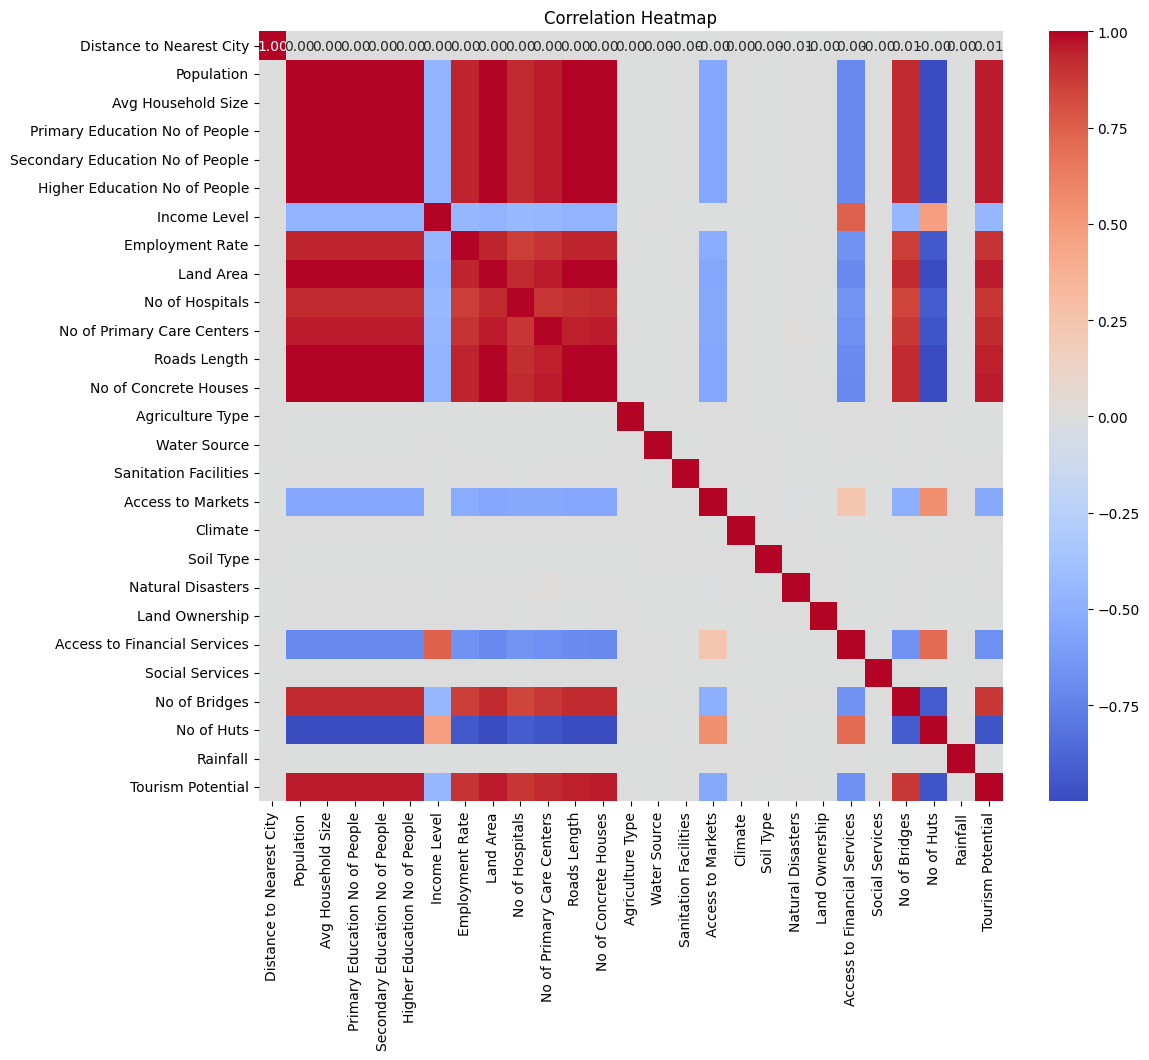

                                  Distance to Nearest City  Population  \
Distance to Nearest City                              1.00        0.00   
Population                                            0.00        1.00   
Avg Household Size                                    0.00        1.00   
Primary Education No of People                        0.00        1.00   
Secondary Education No of People                      0.00        1.00   
Higher Education No of People                         0.00        1.00   
Income Level                                          0.00       -0.47   
Employment Rate                                       0.00        0.94   
Land Area                                             0.00        1.00   
No of Hospitals                                       0.00        0.92   
No of Primary Care Centers                            0.00        0.96   
Roads Length                                          0.00        0.99   
No of Concrete Houses                 

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Display the correlation matrix
print(correlation_matrix.round(2))

#### The correlation matrix reveals numerous perfect correlations (1 or -1), which can obscure other potentially significant relationships. To gain a clearer understanding, we'll filter the correlation matrix to display only correlations that are less than 1 (in absolute value) and exceed a certain threshold, indicating a substantial association between features. We'll set this threshold to 0.5 (absolute value).



In [38]:
# Filter the correlation matrix to include only pairs with absolute correlation between 0.5 and 1
significant_correlations = correlation_matrix[((correlation_matrix > 0.5) | (correlation_matrix < -0.5)) & (correlation_matrix != 1.00)].round(2)

# Display the significant correlations
print("Significant Correlations:\n")
print(significant_correlations)

Significant Correlations:

                                  Distance to Nearest City  Population  \
Distance to Nearest City                               NaN         NaN   
Population                                             NaN         NaN   
Avg Household Size                                     NaN        1.00   
Primary Education No of People                         NaN        1.00   
Secondary Education No of People                       NaN        1.00   
Higher Education No of People                          NaN        1.00   
Income Level                                           NaN         NaN   
Employment Rate                                        NaN        0.94   
Land Area                                              NaN        1.00   
No of Hospitals                                        NaN        0.92   
No of Primary Care Centers                             NaN        0.96   
Roads Length                                           NaN        0.99   
No of Concr

Here are some types of questions that can be answered with a relatively high level of confidence from this dataset:

#### Relationship between settlement characteristics: These questions explore how different aspects of the settlements, such as population, education, infrastructure, and access to services, relate to each other.

- Example: How does population size relate to the level of education in a settlement?
- Example: Is there a correlation between infrastructure development and access to financial services?
#### Comparison of settlements: You can compare different settlements based on their overall characteristics or specific aspects like education levels or access to services.

- Example: Which settlements have the highest levels of education and infrastructure development?
- Example: Which settlements have the poorest access to markets and financial services?

#### Impact of combined factors: These questions analyze how multiple factors work together to influence a particular outcome.

- Example: How do population size, education levels, and infrastructure development collectively influence income levels in a settlement?
- Example: Does the combination of access to markets and financial services have a significant impact on the overall well-being of a settlement?
#### Identification of trends or patterns: You can look for general trends or patterns in the data.

- Example: Do settlements with higher population densities tend to have better infrastructure?
- Example: Is there a general trend of increasing access to services with higher levels of education?
Caution: Due to the high degree of multicollinearity, it's crucial to be cautious when interpreting the results. The focus should be on understanding the combined influence of features or overall trends rather than isolating the effect of individual features.